In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings("ignore")

In [4]:
Data_Set = Path(r"C:\Users\HP\Downloads\1730285881-Airbnb_Open_Data.xlsx")
SHEET = 0
MODEL_SAVE_PATH = "airbnb_best_model.joblib"
SAMPLE_SAVE_PATH = "airbnb_sample.csv"
RANDOM_STATE = 42

In [5]:
if not Data_Set.exists():
    raise FileNotFoundError(f"Dataset not found: {Data_Set}")

xls = pd.ExcelFile(Data_Set)
print("Available sheets:", xls.sheet_names)
df = pd.read_excel(xls, sheet_name=SHEET)
print("Loaded shape:", df.shape)

Available sheets: ['in']
Loaded shape: (102599, 26)


In [6]:
print("\nHead:")
print(df.head(5))
print("\nDatatypes:")
print(df.dtypes)
print("\nMissing values (top 30):")
print(df.isna().sum().sort_values(ascending=False).head(30))


Head:
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee  minimum nights  \
0  40.64749 -73.97237  U

In [7]:
# Detecting the target variable for model training
target_col = None

# Step 1: Try to locate a column explicitly named 'price'
price_candidates = [col for col in df.columns if col.strip().lower() == "price"]
if price_candidates:
    target_col = price_candidates[0]
else:
    # Step 2: If not found, search among numeric columns
    num_features = df.select_dtypes(include=np.number).columns

    # Exclude columns that have very few unique values (like IDs or constants)
    valid_targets = [col for col in num_features if df[col].nunique() > 5]

    if not valid_targets:
        raise RuntimeError("Could not find any suitable numeric target column.")

    # Pick the numeric column with the largest mean value (likely the target)
    target_col = max(valid_targets, key=lambda x: df[x].mean())
    print(f"'price' column missing — defaulting to '{target_col}' as target.")
    
# Final confirmation message
print(f" Target column selected: '{target_col}'")


 Target column selected: 'price'


In [8]:
# Clean target if string-like
if df[target_col].dtype == object:
    df[target_col] = df[target_col].astype(str).str.replace(r"[^\d\.]", "", regex=True).replace("", np.nan).astype(float)

# Drop missing targets
df = df[~df[target_col].isna()].copy()
print("Finally dropping the missing targets:", df.shape)

Finally dropping the missing targets: (102352, 26)


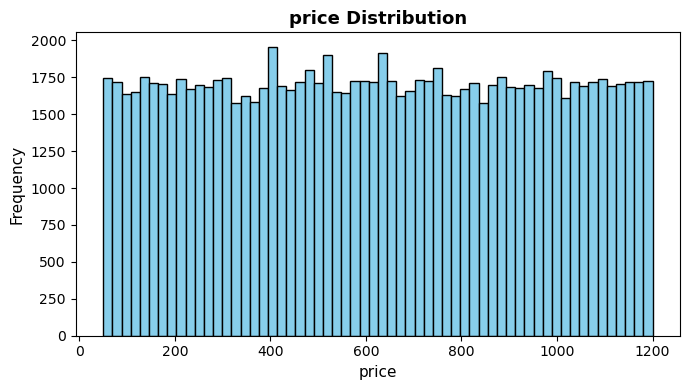

In [9]:
# Visualize the distribution of the target variable
fig, ax = plt.subplots(figsize=(7, 4))

# Drop missing values and plot histogram
data_values = df[target_col].dropna()
ax.hist(data_values, bins=60, color='skyblue', edgecolor='black')

# Add titles and labels
ax.set_title(f"{target_col} Distribution", fontsize=13, fontweight='bold')
ax.set_xlabel(target_col, fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [10]:
# Location top values if exists
loc_cols = [c for c in df.columns if "neigh" in c.lower() or "city" in c.lower() or "district" in c.lower() or "location" in c.lower()]
if loc_cols:
    loc_col = loc_cols[0]
    print(f"\nTop 10 values in {loc_col}:")
    print(df[loc_col].value_counts().nlargest(10))



Top 10 values in neighbourhood group:
neighbourhood group
Manhattan        43682
Brooklyn         41749
Queens           13234
Bronx             2705
Staten Island      952
brookln              1
manhatan             1
Name: count, dtype: int64



Top 10 values in neighbourhood group:
neighbourhood group
Manhattan        43682
Brooklyn         41749
Queens           13234
Bronx             2705
Staten Island      952
brookln              1
manhatan             1
Name: count, dtype: int64


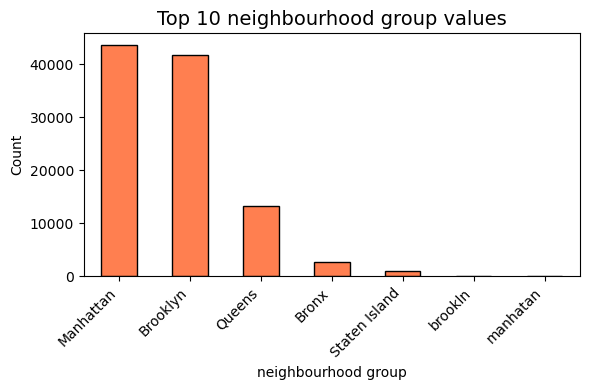

In [11]:
# Find location column if it exists
loc_cols = [c for c in df.columns if "neigh" in c.lower() or "city" in c.lower() or "district" in c.lower() or "location" in c.lower()]

if loc_cols:
    loc_col = loc_cols[0]
    top_locations = df[loc_col].value_counts().nlargest(10)

    print(f"\nTop 10 values in {loc_col}:")
    print(top_locations)

    # Plot
    plt.figure(figsize=(6,4))
    top_locations.plot(kind="bar", color="coral", edgecolor="black")

    plt.title(f"Top 10 {loc_col} values", fontsize=14)
    plt.xlabel(loc_col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No location-related columns found in dataframe.")



 Top correlated features with target column:
price                 1.000000
service fee           0.999991
id                    0.006739
lat                   0.005900
number of reviews     0.005229
review rate number    0.004576
reviews per month     0.004186
host id               0.003837
Construction year     0.003753
minimum nights        0.003471
Name: price, dtype: float64


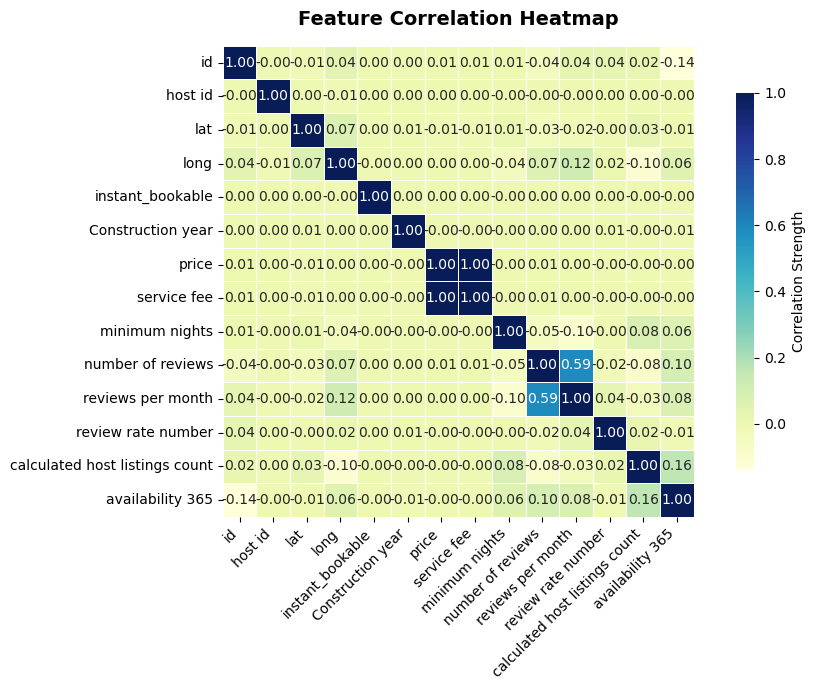

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
num_data = df.select_dtypes(include=np.number)

if num_data.shape[1] > 1:
    # Compute correlation matrix
    corr_matrix = num_data.corr(numeric_only=True)

    # Show top correlations with the target variable
    print("\n Top correlated features with target column:")
    top_corr = (
        corr_matrix[target_col]
        .abs()
        .sort_values(ascending=False)
        .head(10)
    )
    print(top_corr)

    # --- Improved Visualization ---
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        corr_matrix,
        cmap="YlGnBu",           # soft blue-green color scheme
        annot=True,              # display correlation values
        fmt=".2f",
        linewidths = 0.5,
        square=True,
        cbar_kws={"shrink": 0.8, "label": "Correlation Strength"}
    )

    plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold", pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print(" Not enough numeric features available to calculate correlations.")



In [13]:
# Features + target
X = num_data.drop(columns=[target_col], errors='ignore').copy()
y = df[target_col].copy()

In [14]:
# Add categorical encodings for low-cardinality cols
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_low = [c for c in cat_cols if 1 < df[c].nunique() <= 20]
print("\nCategorical columns encoded:", cat_low)

for c in cat_low:
    top_vals = df[c].value_counts().nlargest(10).index.tolist()
    for val in top_vals:
        X[f"{c}__is__{val}"] = (df[c] == val).astype(int)


Categorical columns encoded: ['host_identity_verified', 'neighbourhood group', 'cancellation_policy', 'room type']


In [15]:
# Fill NaNs
X = X.fillna(X.median())

In [16]:
# Splitting the data by using training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("\nShapes:", X_train.shape, X_test.shape)



Shapes: (81881, 29) (20471, 29)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ----- Baseline Model (Mean Predictor) -----
# The simplest model that predicts the average of the training target for all test samples

avg_target = y_train.mean()                     # mean of training set
baseline_predictions = np.full_like(y_test, avg_target, dtype=float)

# Evaluate baseline performance
mae_score = mean_absolute_error(y_test, baseline_predictions)
rmse_score = np.sqrt(mean_squared_error(y_test, baseline_predictions))
r2_val = r2_score(y_test, baseline_predictions)

# Display results neatly
print("\nBaseline Model Performance (Mean Predictor)")
print("------------------------------------------------")
print(f"Mean Absolute Error (MAE): {mae_score:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_score:.2f}")
print(f"R² Score: {r2_val:.3f}")



Baseline Model Performance (Mean Predictor)
------------------------------------------------
Mean Absolute Error (MAE): 286.99
Root Mean Squared Error (RMSE): 332.20
R² Score: -0.000


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# ----- Model Setup -----
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, 
        random_state=RANDOM_STATE, 
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200, 
        random_state=RANDOM_STATE
    )
}

# ----- Model Training & Evaluation -----
model_performance = {}

for model_name, model_obj in regressors.items():
    print(f"\nTraining model: {model_name}")
    
    # Train
    model_obj.fit(X_train, y_train)
    
    # Predict
    y_pred = model_obj.predict(X_test)
    
    # Evaluate
    mae_val = mean_absolute_error(y_test, y_pred)
    rmse_val = mean_squared_error(y_test, y_pred, squared=False)
    r2_val = r2_score(y_test, y_pred)
    
    # Store results
    model_performance[model_name] = {
        "MAE": mae_val,
        "RMSE": rmse_val,
        "R2": r2_val,
        "Model": model_obj
    }

    print(f"{model_name} Results → MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, R²: {r2_val:.3f}")

# ----- Create Results Summary Table -----
results_table = (
    pd.DataFrame(model_performance)
      .T
      .sort_values(by="R2", ascending=False)
      .reset_index()
      .rename(columns={"index": "Model"})
)

print("\nModel Performance Summary:\n")
display(results_table)



Training model: Linear Regression
Linear Regression Results → MAE: 2.09, RMSE: 18.33, R²: 0.997

Training model: Random Forest
Random Forest Results → MAE: 2.08, RMSE: 19.17, R²: 0.997

Training model: Gradient Boosting
Gradient Boosting Results → MAE: 2.95, RMSE: 19.16, R²: 0.997

Model Performance Summary:



,Model,MAE,RMSE,R2,Model
0,Linear Regression,2.08606,18.325927,0.996957,LinearRegression()
1,Gradient Boosting,2.953875,19.1647,0.996672,([DecisionTreeRegressor(criterion='friedman_ms...
2,Random Forest,2.077514,19.165251,0.996672,"(DecisionTreeRegressor(max_features=1.0, rando..."


'Model     Linear Regression
Model    LinearRegression()
Name: 0, dtype: object' not found in model_performance keys: ['Linear Regression', 'Random Forest', 'Gradient Boosting']
 Model 'Model     Linear Regression
Model    LinearRegression()
Name: 0, dtype: object' does not support feature importances.


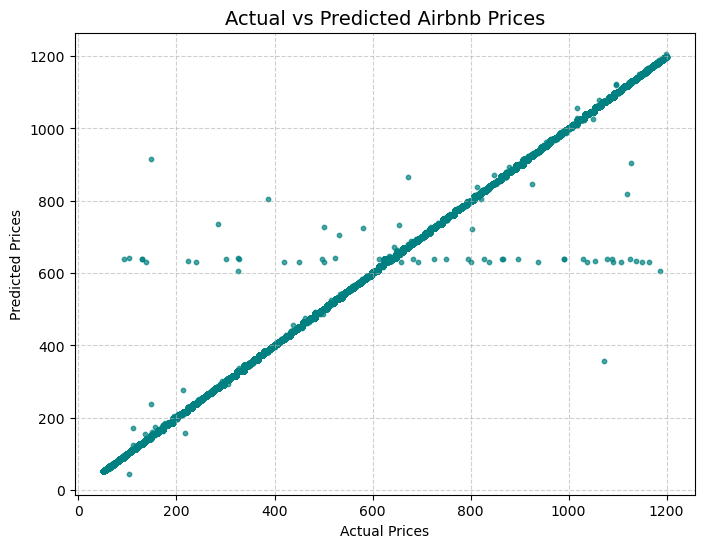

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----- Get Best Model Based on R2 -----
# Ensure column names are consistent and accessible
best_row = results_table.sort_values("R2", ascending=False).iloc[0]
best_name = str(best_row["Model"]).strip()  

# Ensure the key actually exists in the performance dictionary
if best_name not in model_performance:
    print(f"'{best_name}' not found in model_performance keys: {list(model_performance.keys())}")
else:
    best = model_performance[best_name]["Model"]
    best_r2 = model_performance[best_name]["R2"]

    # ----- Predictions -----
    y_pred_best = best.predict(X_test)

    # ----- Actual vs Predicted Plot -----
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred_best, s=10, alpha=0.7, color='teal')
    minv, maxv = min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())
    plt.plot([minv, maxv], [minv, maxv], 'r--', lw=2)
    plt.xlabel(f"Actual {target_col}")
    plt.ylabel(f"Predicted {target_col}")
    plt.title(f"Actual vs Predicted - {best_name} (R²={best_r2:.3f})")
    plt.tight_layout()
    plt.show()
    


    # ----- Feature Importances (if available) -----
if hasattr(best_name, "feature_importances_"):
        feature_imp = pd.Series(best.feature_importances_, index=X_train.columns)
        top_features = feature_imp.sort_values(ascending=False).head(30)

        print("\nTop 30 Feature Importances:")
        print(top_features)

        plt.figure(figsize=(10,6))
        plt.bar(top_features.index, top_features.values, color='orange', edgecolor='black')
        plt.xticks(rotation=90)
        plt.title(f"Top Feature Importances - {best_name}")
        plt.tight_layout()
        plt.show()
else:
    print(f" Model '{best_name}' does not support feature importances.")
    
import matplotlib.pyplot as plt

# Scatter plot: Actual vs Predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, s=10, alpha=0.7, color='teal')
plt.title("Actual vs Predicted Airbnb Prices", fontsize=14)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [22]:
# Save model + sample
joblib.dump(best_name, MODEL_SAVE_PATH)
pd.concat([X, y], axis=1).sample(n=min(2000, len(X))).to_csv(SAMPLE_SAVE_PATH, index=False)
print(f"\nSaved best model ({best_name}) to {MODEL_SAVE_PATH}")
print(f"Saved cleaned sample CSV to {SAMPLE_SAVE_PATH}")

print("\nDone ")


Saved best model (Model     Linear Regression
Model    LinearRegression()
Name: 0, dtype: object) to airbnb_best_model.joblib
Saved cleaned sample CSV to airbnb_sample.csv

Done 
